Fill in the missing code (#####).  Here you learn to use the pearson_loss function, the penalized_pearson_loss function and the pearson_metric function. See important comment at the end.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from matplotlib import pyplot
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import keras.backend as K
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
import keras

Using TensorFlow backend.


Here we program the pearson_loss function using tensors

In [2]:
def pearson_loss(y_true, y_pred):
    """Pearson correlation coefficient"""

    x = y_true
    y = y_pred
    xm, ym = x - K.mean(x), y - K.mean(y)
    r_num = K.sum(tf.multiply(xm, ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / (r_den + K.epsilon())
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    
    return  tf.constant(1.0, dtype=x.dtype) - K.square(r)

Next we program another version, a penalized_pearson_loss.

The penalized_pearson_loss maximizes the pearson correlation coefficient between the predicted values and the labels, while trying to have the same mean and variance.  It is the same as pearson_loss except for the addition of a penalty term (0.01*sqdif) so it deals with  noise better:https://archive.md/k5aTF

In [3]:
def penalized_pearson_loss(x,y, axis=-2):
    """Penalized Pearson correlation coefficient"""
    x = tf.convert_to_tensor(x)
    y = K.cast(y, x.dtype)
    n = tf.cast(tf.shape(x)[axis], x.dtype)
    xsum = tf.reduce_sum(x, axis=axis)
    ysum = tf.reduce_sum(y, axis=axis)
    xmean = xsum / n
    ymean = ysum / n
    xsqsum = tf.reduce_sum( tf.math.squared_difference(x, xmean), axis=axis)
    ysqsum = tf.reduce_sum( tf.math.squared_difference(y, ymean), axis=axis)
    cov = tf.reduce_sum( (x - xmean) * (y - ymean), axis=axis)
    corr = cov / (tf.sqrt(xsqsum * ysqsum)+ K.epsilon())
    sqdif = tf.reduce_sum(tf.math.squared_difference(x, y), axis=axis) / n / tf.sqrt(ysqsum / n)
    return tf.convert_to_tensor( K.mean(tf.constant(1.0, dtype=x.dtype) - corr + (0.01 * sqdif)) , dtype=tf.float32 )

Next we program the pearson_metric function using py_func.

py_func is a tf wrapper for a python function. py_func returns a tensor.
Below we use py_func to wrap around the python function pearsonr.
This use of py_func does NOT work in my setup which is why
I commented out the pearson_metric that uses py_func and intead
I use the pearson_metric underneath that uses tensors.
py_func doesn't always work.

def pearson_metric(y_true, y_pred):
    """Pearson correlation coefficient"""
    
    r = tf.py_function(pearsonr, inp=[y_true, y_pred], Tout=tf.float32)
    
    return  tf.constant(1.0, dtype=y_true.dtype)  - r

In [4]:
def pearson_metric(y_true, y_pred):
    """Pearson correlation coefficient programmed using tensors"""

    x = y_true
    y = y_pred
    xm, ym = x - K.mean(x), y - K.mean(y)
    r_num = K.sum(tf.multiply(xm, ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / (r_den + K.epsilon())
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    
    return tf.constant(1.0, dtype=x.dtype) - K.square(r)

In [7]:
num_features = 20
# generate regression dataset
X, y = make_regression(n_samples=1000, n_features=num_features, noise=0.1, random_state=1)

# split into train and test
n_train = 500
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# reshape 1d arrays to 2d arrays
trainy = trainy.reshape(len(trainy), 1)
testy = testy.reshape(len(trainy), 1)

# create scaler
scaler = StandardScaler()
# fit scaler on training dataset
scaler.fit(trainy)
# transform training dataset
trainy = scaler.transform(trainy)
# transform test dataset
testy = scaler.transform(testy)

# fit scaler on training dataset
scaler.fit(trainX)
# transform training dataset
trainX = scaler.transform(trainX)
# transform test dataset
testX = scaler.transform(testX)

Train on 500 samples, validate on 500 samples
Epoch 1/100
500/500 [==============================] - 2s 5ms/step - loss: 1.0686 - pearson_metric: 0.9433 - val_loss: 0.8568 - val_pearson_metric: 0.9360
Epoch 2/100
500/500 [==============================] - 0s 119us/step - loss: 0.6226 - pearson_metric: 0.7981 - val_loss: 0.3934 - val_pearson_metric: 0.5976
Epoch 3/100
500/500 [==============================] - 0s 125us/step - loss: 0.3358 - pearson_metric: 0.5233 - val_loss: 0.1913 - val_pearson_metric: 0.3246
Epoch 4/100
500/500 [==============================] - 0s 120us/step - loss: 0.1755 - pearson_metric: 0.2987 - val_loss: 0.1181 - val_pearson_metric: 0.2059
Epoch 5/100
500/500 [==============================] - 0s 124us/step - loss: 0.1040 - pearson_metric: 0.1817 - val_loss: 0.0870 - val_pearson_metric: 0.1529
Epoch 6/100
500/500 [==============================] - 0s 112us/step - loss: 0.0760 - pearson_metric: 0.1337 - val_loss: 0.0725 - val_pearson_metric: 0.1276
Epoch 7/100
50

Epoch 53/100
500/500 [==============================] - 0s 97us/step - loss: 0.0068 - pearson_metric: 0.0117 - val_loss: 0.0108 - val_pearson_metric: 0.0194
Epoch 54/100
500/500 [==============================] - 0s 111us/step - loss: 0.0062 - pearson_metric: 0.0107 - val_loss: 0.0105 - val_pearson_metric: 0.0190
Epoch 55/100
500/500 [==============================] - 0s 98us/step - loss: 0.0060 - pearson_metric: 0.0104 - val_loss: 0.0102 - val_pearson_metric: 0.0186
Epoch 56/100
500/500 [==============================] - 0s 112us/step - loss: 0.0060 - pearson_metric: 0.0104 - val_loss: 0.0100 - val_pearson_metric: 0.0181
Epoch 57/100
500/500 [==============================] - 0s 110us/step - loss: 0.0061 - pearson_metric: 0.0108 - val_loss: 0.0097 - val_pearson_metric: 0.0177
Epoch 58/100
500/500 [==============================] - 0s 97us/step - loss: 0.0058 - pearson_metric: 0.0103 - val_loss: 0.0095 - val_pearson_metric: 0.0174
Epoch 59/100
500/500 [==============================] -

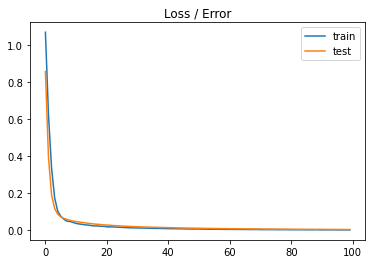

In [10]:
# mlp with scaled inputs outputs on the regression problem using custom loss and custom metric
# define model
model = Sequential()
model.add(Dense(25, input_dim=20, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear'))
# compile model using as loss: penalized_pearson_loss; as metric: pearson_metric AND kears.losses.mean_squared_error
model.compile(loss=penalized_pearson_loss, optimizer=SGD(lr=0.01, momentum=0.9), metrics=[pearson_metric])#####

# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=1)
# evaluate the model
train_e = model.evaluate(trainX, trainy, verbose=1)
test_e = model.evaluate(testX, testy, verbose=1)
print('Train loss: %.3f, Test loss: %.3f' % (train_e[0], test_e[0])) #when using custom loss and custom metric
print('Train metric: %.3f, Test metric: %.3f' % (train_e[1], test_e[1])) #when using custom loss and custom metric
#print('Train loss: %.3f, Test loss: %.3f' % (train_e, test_e)) 
#plot loss during training
plt.title('Loss / Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Since the spearman_loss function for tensorflow 1.5 in spearman_corr_incomplete.ipynb cannot be used without a gradient, you have three options. 

1. You can program a gradient for the function.

2. You can use the spearman_loss function for tensorflow 2.6 in spearman_corr_TSFL2.ipynb (but we have not tested this).  

3. You can use the penalized_pearson_loss function instead of the spearman_loss function (as we have done here).

In [11]:
df = pd.DataFrame(history.history)
df.head(3)

,val_loss,val_pearson_metric,loss,pearson_metric
0,0.856810,0.935969,1.068564,0.943276
1,0.393351,0.597628,0.622568,0.798119
2,0.191330,0.324607,0.335798,0.523260


<AxesSubplot:>

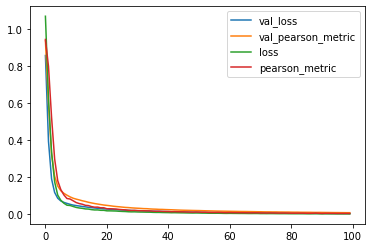

In [12]:
df.plot()

Penalized_pearson_loss has the advantage that it is easy to interpret, unlike MSE or a negative value of R-squared (which can arise in a non-linear model). But it has a disadvantage: When penalized_pearson_loss is used as loss (as it is used here), it minimizes 1-covariance and distance.  But it does so at different rates: it minimizes 1-covariance quickly and distance more slowly. This is why, when using the penalized_pearson_loss, the mse_metric converges more slowly. But the important thing is that it (MSE, distance) eventually converges after about 70 epochs.

For non-linear models you can use loss: MSE ('mean_squared_error'), and metric: pearson_metric. You can also experiment with loss: penalized_pearson_loss, and metric: kears.losses.mean_squared_error, making sure that convergence is happening. 

To see more about the comparative performance of the penalized_pearson_loss, see pearson_corr_TSFL2_EXTRADOCUMENTATION.ipynb (running the ipynb requires tensorflow 2, but you can see the graphs which show that the penalized_pearson_loss minimizes well while dealing with noisy data.) 